In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv', encoding="ISO-8859-1")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# **Data Understanding**

**Variable Description**
- **InvoiceNo**    Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode**    Code uniquely assigned to each distinct product.
- **Description**  Description of each product.
- **Quantity** 	   The number of units of a product in a transaction.
- **InvoiceDate**  The date and time of the transaction.
- **UnitPrice**    The unit price of the product in sterling.
- **CustomerID**   Identifier uniquely assigned to each customer.
- **Country**      The country of the customer.

In [3]:
# information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We notice that the dataset consists of 8 features, encompassing both string and numerical types. Specifically, there are 5 object (string) features and 3 numerical features. Additionally, it's evident that there are missing values present in the dataset, which we will address later on.

In [4]:
# some simple statistics
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


From the simple statistics provided, we can discern a significant disparity between the mean and standard deviation of the Quantity and UnitPrice features. The mean Quantity is approximately 9.55, while the standard deviation is substantially larger at around 218.08. Similarly, for the UnitPrice feature, the mean is approximately 4.61, with a considerably higher standard deviation of approximately 96.76. Such a pronounced gap between the mean and standard deviation suggests the presence of outliers within our dataset

In [5]:
# Statistics for categorical variables
data.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [6]:
# check the messing values in the data
percentage_missing =( data.isnull().sum() / data.shape[0] * 100)
percentage_missing

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Almost a quarter (25%) of the customers remain unidentified in the dataset. Additionally, there's a mere 0.25% of missing descriptions, which indicates potential data cleanliness issues.

# **Some Data Analysis**

- ### Which StockCode for product are most sold?


C:\Users\ismai\AppData\Local\Temp\ipykernel_8836\2148975645.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stockcode_counts.iloc[0:20].index,


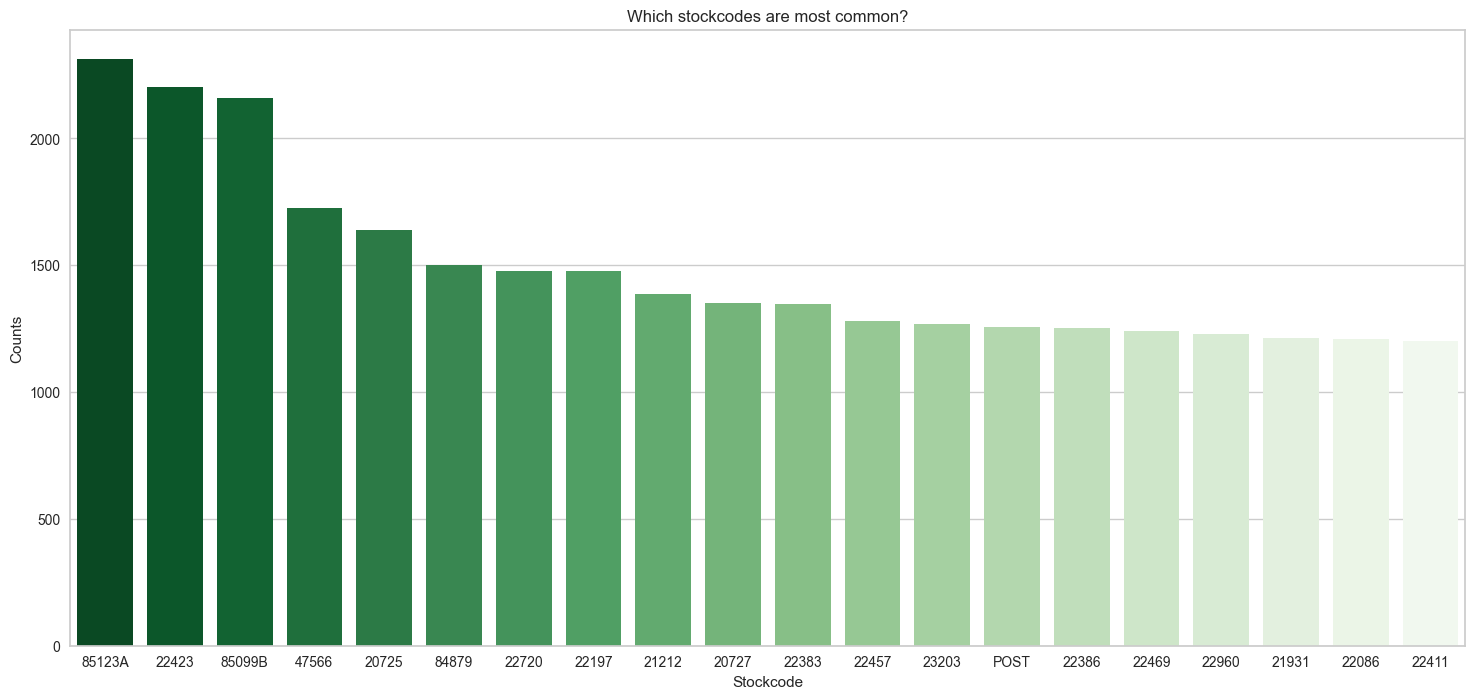

In [7]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(18,8))  
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax=ax, palette="Greens_r",
            legend=False)
ax.set_ylabel("Counts")
ax.set_xlabel("Stockcode")
ax.set_title("Which stockcodes are most common?")
plt.show() 

In [8]:
# most 3 products
product_1 = data.query('StockCode == "85123A"')["Description"].iloc[0]
product_2 = data.query('StockCode == "22423"')["Description"].iloc[0]
product_3 = data.query('StockCode == "85099B"')["Description"].iloc[0]

# sort the product whith quantity solde
products = [product_1 ,product_2 ,product_3 ]
for i in products:
    product_counts = data[data['Description'].isin([i])]['Quantity'].sum()
    print(f'{i} : {product_counts}')


WHITE HANGING HEART T-LIGHT HOLDER : 35317
REGENCY CAKESTAND 3 TIER : 13033
JUMBO BAG RED RETROSPOT : 47363


The three most common products sold appear to be the following:

    1: WHITE HANGING HEART T-LIGHT HOLDER
    2: REGENCY CAKESTAND 3 TIER
    3: JUMBO BAG RED RETROSPOT

**"WHITE HANGING HEART T-LIGHT HOLDER"** emerges as the best-selling item, with a remarkable quantity sold of 35,317 units. Following closely is the **"REGENCY CAKESTAND 3 TIER"** with a substantial sales volume of 13,033 units. Lastly, the **"JUMBO BAG RED RETROSPOT"** stands out with an impressive quantity sold of 47,363 units.

- ### Most Customers

C:\Users\ismai\AppData\Local\Temp\ipykernel_8836\2145033153.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_counts.values,


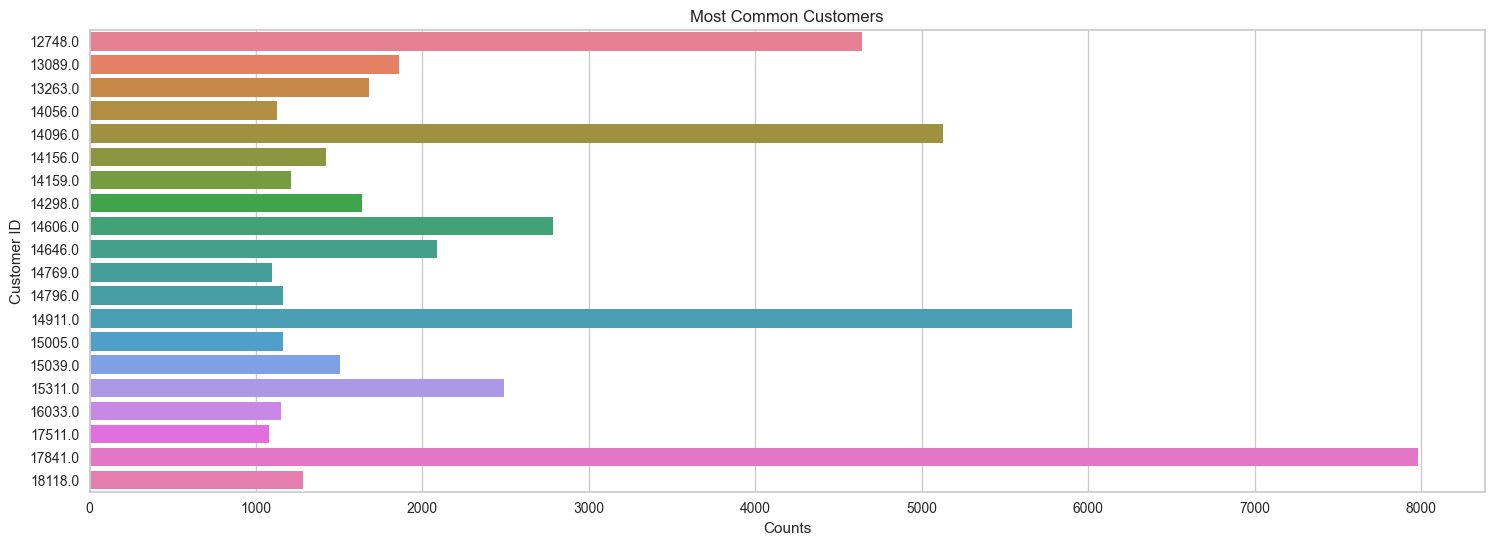

In [21]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False)
customer_counts = customer_counts.iloc[0:20][::-1]  
fig, ax = plt.subplots(figsize=(18,6))  
colors = sns.color_palette("husl", len(customer_counts))
sns.barplot(x=customer_counts.values,
            y=customer_counts.index,
            ax=ax, 
            palette=colors, 
            orient='h')  

ax.set_xlabel("Counts")
ax.set_ylabel("Customer ID")
ax.set_title("Most Common Customers")
plt.show()

- ### Check the transactions

**InvoiceNo**    Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.

In [10]:
# Extracting rows where 'InvoiceNo' starts with 'C'
cancellation_data = data[data['InvoiceNo'].str.startswith('C')]

# Displaying the extracted data
cancellation_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


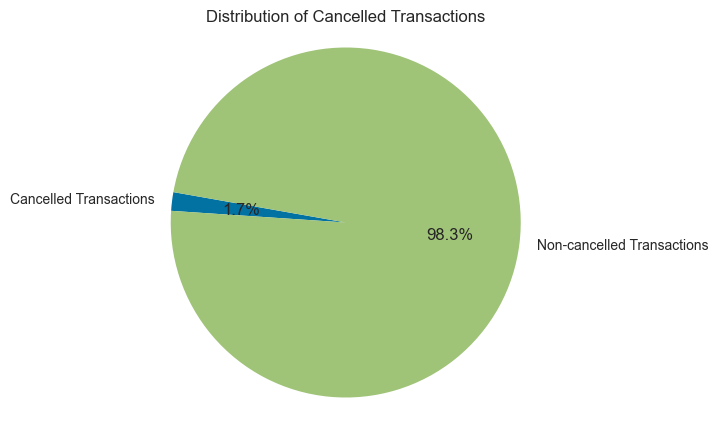

In [11]:
cancellation_transaction = data['InvoiceNo'].str.startswith('C').sum()
total_transactions = len(data['InvoiceNo'])
cancellation_percentage = (cancellation_transaction / total_transactions) * 100

# Plotting the pie chart
plt.figure(figsize=(6, 5))
plt.pie([cancellation_percentage, 100 - cancellation_percentage],
        labels=['Cancelled Transactions', 'Non-cancelled Transactions'],
        autopct='%1.1f%%', startangle=170)
plt.title('Distribution of Cancelled Transactions')
plt.axis('equal') 
plt.show()


Out of all unique transactions, only 1, or roughly 1.7%, are cancellations, leaving the vast majority as non-cancelled transactions. This low percentage suggests a well-managed order fulfillment process with minimal errors or customer dissatisfaction

In [12]:
# copy the data and leve the original with no modifecation yet 
df = data.copy()

In [13]:
# Convert 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract year, month, and day and add them as separate columns
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] =df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day

# Display the updated DataFrame
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1


In [14]:
year_10 = df.query('Year ==2010')['Quantity'].sum()
year_11 = df.query('Year ==2011')['Quantity'].sum()
print(f'quantity solde in 2010: {year_10}')
print(f'quantity solde in 2011: {year_11}')

quantity solde in 2010: 342228
quantity solde in 2011: 4834222


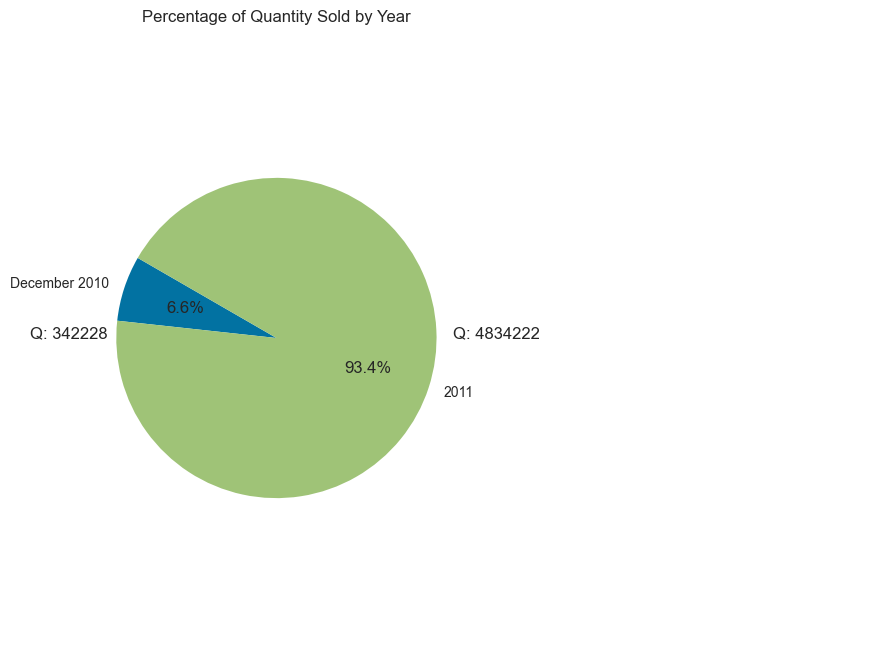

In [15]:
# Calculate total quantity sold
total_quantity_10 = year_10
total_quantity_11 = year_11

# Calculate percentages
percentage_10 = (year_10 / (year_10 + year_11)) * 100
percentage_11 = (year_11 / (year_10 + year_11)) * 100

# Plotting the pie chart
plt.figure(figsize=(10, 8))

# Plotting the pie chart
plt.subplot(121)
plt.pie([percentage_10, percentage_11], labels=['December 2010', '2011'], autopct='%1.1f%%', startangle=150)
plt.title('Percentage of Quantity Sold by Year')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adding total quantity sold outside the pie chart
plt.subplot(122)
plt.text(-1.4, 0.5, f'Q: {total_quantity_10}', fontsize=12)
plt.text(-0.2, 0.5, f'Q: {total_quantity_11}', fontsize=12)
plt.axis('off')  # Turn off axis for annotation subplot

plt.show()


The data indicates a notable difference in sales between December 2010 and the entirety of 2011. In December 2010 alone, a total of 342,228 items were sold, while in 2011, sales substantially increased to 4,834,222 items. This significant growth in sales from December 2010 to 2011 suggests successful strategies or shifts in consumer demand during that period. The combined total quantity sold over the two periods amounts to 5,176,450 items, highlighting an overall positive trend.

- ### Comparison between the Quantity sold and the Qales revenue for each month in 2011

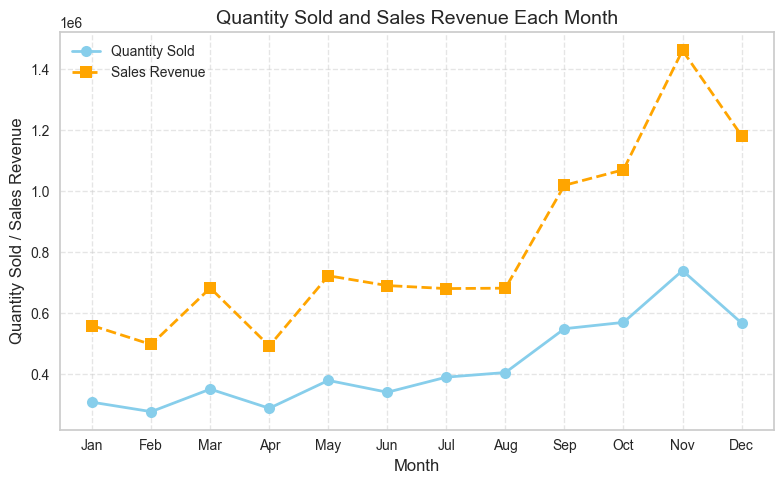

In [39]:
# Calculate sales revenue by multiplying quantity sold by unit price
df['SalesRevenue'] = df['Quantity'] * df['UnitPrice']

# Group by month and sum the quantities sold and sales revenue
monthly_data = df.groupby('Month').agg({'Quantity':'sum', 'SalesRevenue':'sum'})

# Plotting the line chart with stylish customization
plt.figure(figsize=(8, 5))
plt.plot(monthly_data.index, monthly_data['Quantity'], marker='o', linestyle='-', color='skyblue', label='Quantity Sold', linewidth=2, markersize=8)
plt.plot(monthly_data.index, monthly_data['SalesRevenue'], marker='s', linestyle='--', color='orange', label='Sales Revenue', linewidth=2, markersize=8)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Quantity Sold / Sales Revenue', fontsize=12)
plt.title('Quantity Sold and Sales Revenue Each Month', fontsize=14)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [41]:
# revenu by month
monthly_data

,Quantity,SalesRevenue
Month,,
1,308966,560000.260
2,277989,498062.650
3,351872,683267.080
4,289098,493207.121
5,380391,723333.510
6,341623,691123.120
7,391116,681300.111
8,406199,682680.510
9,549817,1019687.622


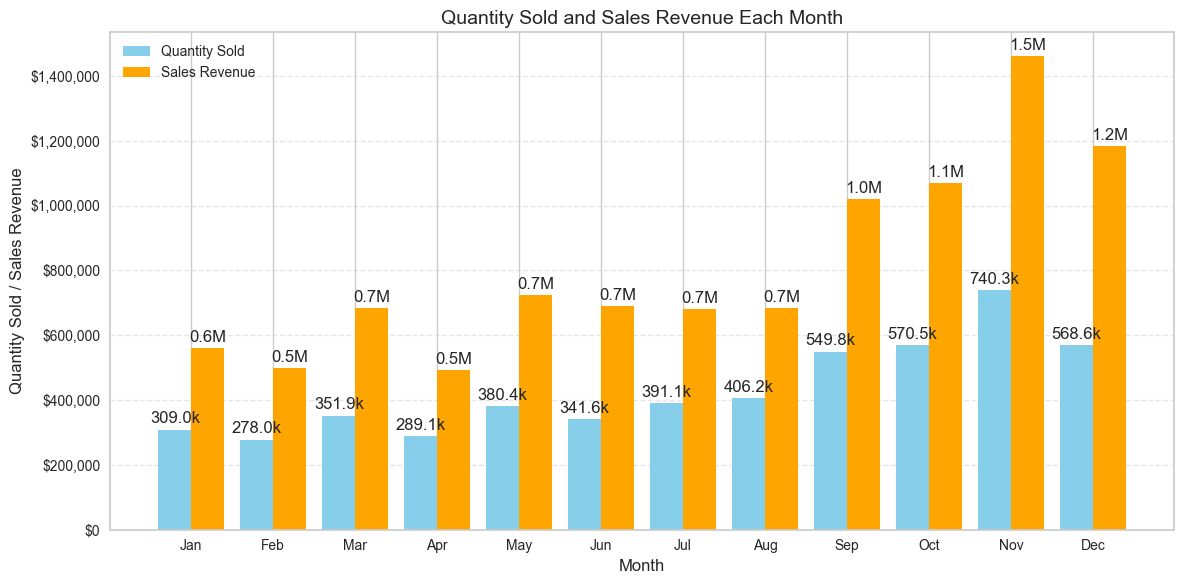

In [42]:
import matplotlib.ticker as mtick

datas = {
    'Month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Quantity': [308966, 277989, 351872, 289098, 380391, 341623, 391116, 406199, 549817, 570532, 740286, 568561],
    'SalesRevenue': [560000.26, 498062.65, 683267.08, 493207.12, 723333.51, 691123.12, 681300.11, 682680.51, 1019687.622, 1070704.67, 1461756.25, 1182625.03]
}

# Create DataFrame
dfs = pd.DataFrame(datas)

# Plotting the bar chart
plt.figure(figsize=(12, 6))

# Plotting quantity sold for all months
plt.bar(dfs['Month'] - 0.2, dfs['Quantity'], width=0.4, color='skyblue', label='Quantity Sold')

# Plotting sales revenue
plt.bar(dfs['Month'] + 0.2, dfs['SalesRevenue'], width=0.4, color='orange', label='Sales Revenue')

# Adding numbers on top of each bar
for i, val in enumerate(dfs['Quantity']):
    plt.text(i + 0.8, val + 10000, f'{val/1e3:.1f}k', ha='center', va='bottom')

for i, val in enumerate(dfs['SalesRevenue']):
    plt.text(i + 1.2, val + 10000, f'{val/1e6:.1f}M', ha='center', va='bottom')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Quantity Sold / Sales Revenue', fontsize=12)
plt.title('Quantity Sold and Sales Revenue Each Month', fontsize=14)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.show()


The bar chart presents a comparison between the quantity sold and the sales revenue for each month, based on the provided information.

In January, although the quantity sold is relatively high at 308,966 items, the corresponding sales revenue stands at $560,000.26, suggesting a balance between sales volume and revenue generation.

February continues this trend with a slightly lower quantity sold of 277,989 items, resulting in a sales revenue of $498,062.65.

March sees a significant increase in both quantity sold and sales revenue, with 351,872 items sold, contributing to a revenue of $683,267.08. This suggests a strong demand for products during this period, leading to increased sales revenue.

April experiences a slight decrease in both quantity sold and revenue compared to March, with 289,098 items sold and revenue of $493,207.12.

May marks a notable upsurge in both quantity sold and sales revenue, with 380,391 items sold and revenue reaching $723,333.51. This suggests heightened consumer activity and increased spending during this period.

June maintains a similar level of sales activity as May, with 341,623 items sold and revenue totaling $691,123.12.

July and August see further increases in both quantity sold and revenue, indicating sustained growth in sales performance during the summer months.

September witnesses a substantial spike in both quantity sold and revenue, with 549,817 items sold and revenue soaring to $1,019,687.62. This significant increase may be attributed to various factors such as seasonal demand, promotional activities, or new product launches.

October and November continue this upward trajectory, with sales reaching 570,532 and 740,286 items respectively, and corresponding revenues of $1,070,704.67 and $1,461,756.25. These months likely benefit from increased consumer spending during the holiday season.

December concludes the year with strong sales performance, with 568,561 items sold and revenue amounting to $1,182,625.03, indicating robust demand and revenue generation during the festive period.

Overall, the bar chart highlights the fluctuations in sales volume and revenue throughout the year, providing insights into consumer behavior, seasonal trends, and the performance of the business over time.

- ### Top 10 Countries by Sales Revenue

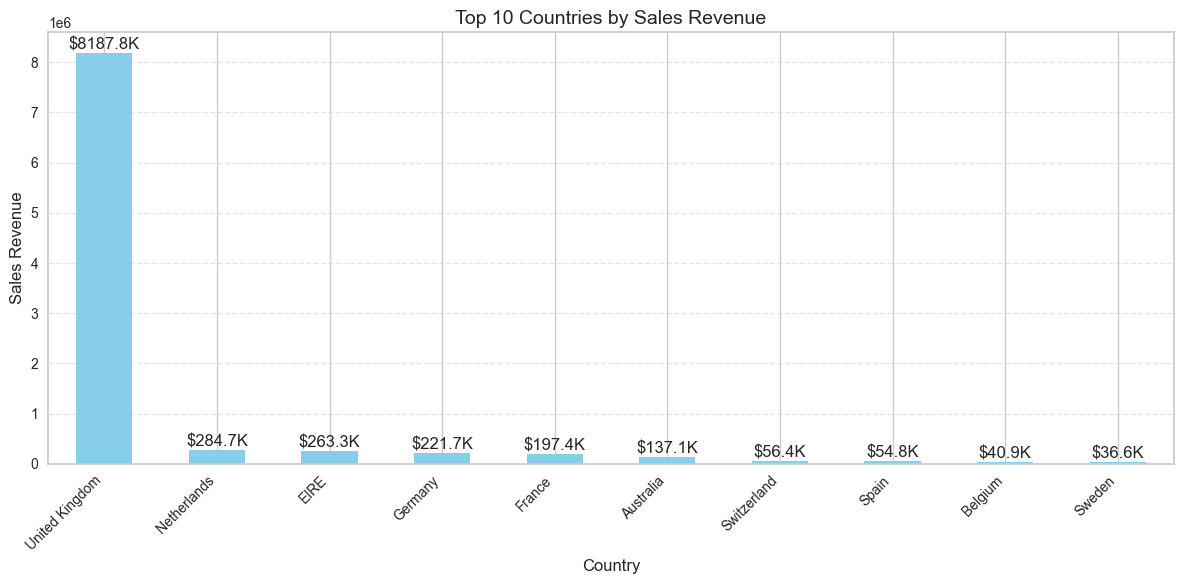

In [49]:
# Group by country and sum the sales revenue
revenue_by_country = df.groupby('Country')['SalesRevenue'].sum()

# Select the top 10 countries with the highest revenue
top_10_countries = revenue_by_country.nlargest(10)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
top_10_countries.plot(kind='bar', color='skyblue')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Sales Revenue', fontsize=12)
plt.title('Top 10 Countries by Sales Revenue', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding numbers on top of each bar
for i, val in enumerate(top_10_countries):
    plt.text(i, val + 10000, f'${val/1e3:.1f}K', ha='center', va='bottom')

plt.tight_layout()
plt.show()


The bar chart depicts the top 10 countries contributing the highest sales revenue to the company, with the United Kingdom leading by a substantial margin, generating a revenue of $8,187,806.36. Following closely, the Netherlands and EIRE stand out with revenues of $284,661.54 and $263,276.82 respectively. Germany and France also make significant contributions, with revenues of $221,698.21 and $197,403.90 respectively.

# **Data Preprocessing**

In [17]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
